<a href="https://colab.research.google.com/github/bannis14/Portfolio-Projects/blob/main/Time_Series_Forecast/Facebook_Prophet_Model_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Facebook Prophet Model Forecasting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


## Libraries and Data

In [ ]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [ ]:
# Load Data
# YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
future_df = pd.read_csv('future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [ ]:
# Merge data sets
df = pd.concat([df, future_df])
df = df.reset_index(drop=True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [ ]:
# rename the variable
df = df.rename(columns={'Demand': 'y',
                        'Date': 'ds'})

In [ ]:
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [ ]:
# Date -> datetime index
df.ds = pd.to_datetime(df.ds, format='%m/%d/%Y')

In [ ]:
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


## Holiday Handling

In [ ]:
# Easter
dates = pd.to_datetime(df[df['Easter'] == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter.head()

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [ ]:
# Thanksgiving
dates = pd.to_datetime(df[df['Thanksgiving'] == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                              'ds': dates,
                              'lower_window': -3,
                              'upper_window': 6})

In [ ]:
thanksgiving.head()

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6


In [ ]:
# Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [ ]:
df = df.drop(columns=['Easter', 'Thanksgiving'])
df.head()

,ds,y,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,3.68,41.305
1,2015-01-02,581.276773,0,4.73,131.574
2,2015-01-03,754.117039,0,7.23,162.700
3,2015-01-04,622.252774,0,10.96,160.281
4,2015-01-05,785.373319,0,6.92,51.077


##Facebook Prophet Model


In [ ]:
# Splitting the data
training = df.iloc[:-31, :]
future_df = df.iloc[-31:, :]

In [ ]:
# Get Best Params
parameters = pd.read_csv("Forecasting Product/best_params_prophet.csv", index_col=0)
parameters

,34
changepoint_prior_scale,0.01
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,10
rmse,48.06303866123096


In [ ]:
# Extract the values
changepoint_prior_scale = float(parameters.loc['changepoint_prior_scale'][0])
holidays_prior_scale = float(parameters.loc['holidays_prior_scale'][0])
seasonality_prior_scale = float(parameters.loc['seasonality_prior_scale'][0])
seasonlity_mode = parameters.loc['seasonality_mode'][0]

In [ ]:
# Prophet Model
m = Prophet(holidays=holidays,
            seasonality_mode=seasonlity_mode,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc3mm0tfz/mvk6iy7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc3mm0tfz/w9x4j0r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49581', 'data', 'file=/tmp/tmpc3mm0tfz/mvk6iy7y.json', 'init=/tmp/tmpc3mm0tfz/w9x4j0r1.json', 'output', 'file=/tmp/tmpc3mm0tfz/prophet_model532652o1/prophet_model-20231113202619.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:26:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:26:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


##Forecasting

In [ ]:
# Create Future dataframe

future = m.make_future_dataframe(periods=len(future_df),
                                 freq='D')
future = pd.concat([future, df.iloc[:, 2:]], axis=1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [ ]:
# Make forecast predictions

forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,594.566158,619.332286,759.130803,594.566158,594.566158,0.0,0.0,0.0,-3.364385,...,-4.050387,-4.050387,-4.050387,90.342508,90.342508,90.342508,0.0,0.0,0.0,688.105581
1,2015-01-02,594.682442,532.450086,669.622662,594.682442,594.682442,0.0,0.0,0.0,0.193030,...,-89.459364,-89.459364,-89.459364,88.983244,88.983244,88.983244,0.0,0.0,0.0,604.027838
2,2015-01-03,594.798727,645.440820,785.977850,594.798727,594.798727,0.0,0.0,0.0,1.419676,...,25.265281,25.265281,25.265281,87.789117,87.789117,87.789117,0.0,0.0,0.0,716.560334
3,2015-01-04,594.915011,561.876157,695.374680,594.915011,594.915011,0.0,0.0,0.0,1.324345,...,-55.613893,-55.613893,-55.613893,86.779136,86.779136,86.779136,0.0,0.0,0.0,631.199430
4,2015-01-05,595.031295,689.332294,831.727956,595.031295,595.031295,0.0,0.0,0.0,-2.979280,...,74.332012,74.332012,74.332012,85.966718,85.966718,85.966718,0.0,0.0,0.0,759.928556


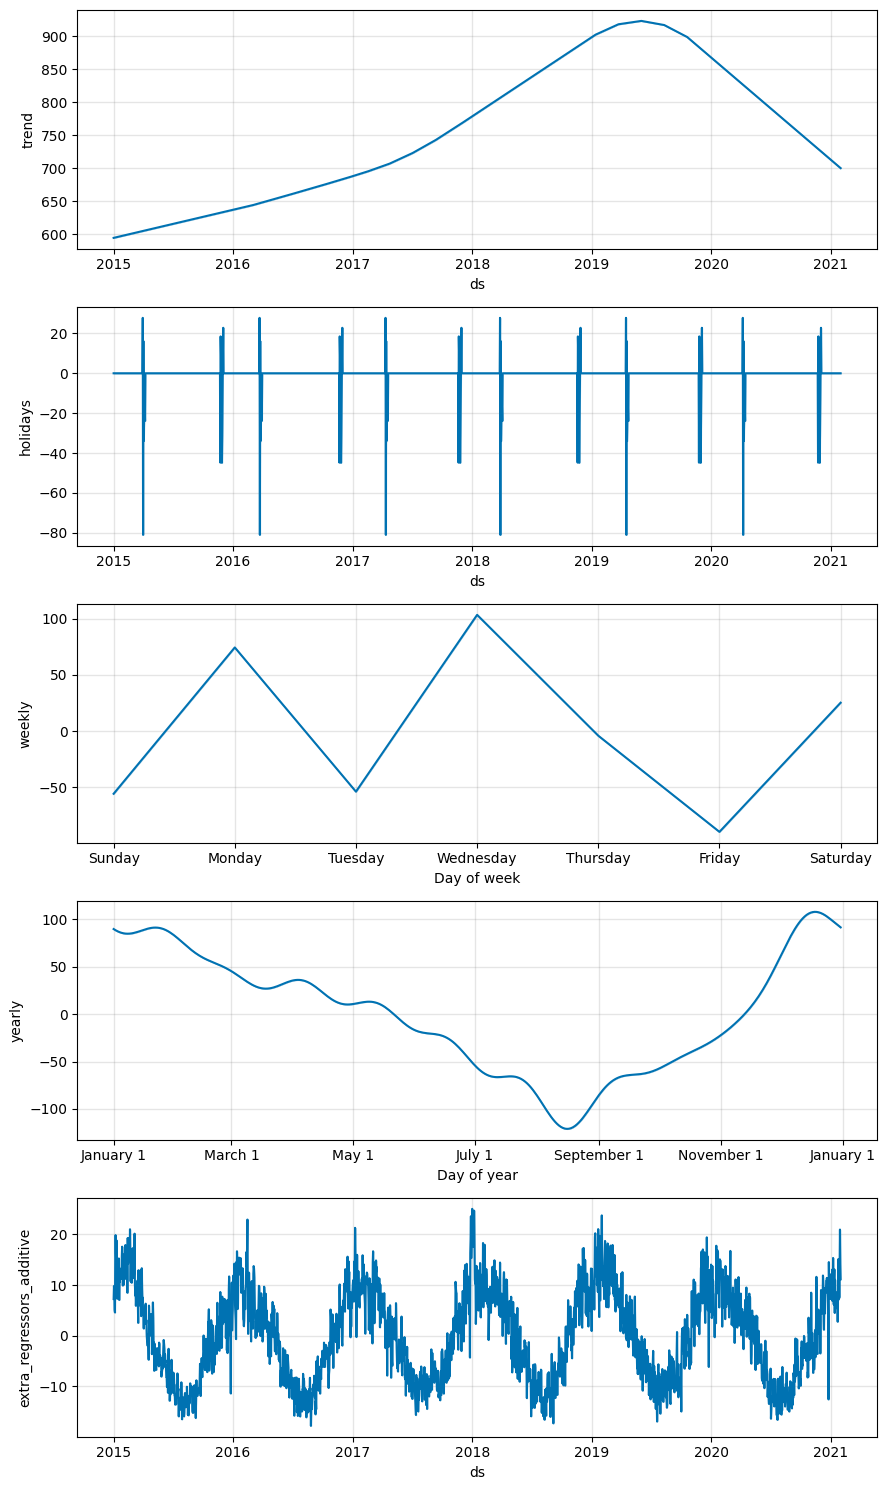

In [ ]:
# Visulization

m.plot_components(forecast);

In [ ]:
#Extracting Predictions

predictions_prophet = forecast.yhat[-len(future_df):].rename('prophet')
predictions_prophet.index = future_df['ds']
predictions_prophet

ds
2021-01-01    723.554897
2021-01-02    835.213356
2021-01-03    753.683264
2021-01-04    880.050649
2021-01-05    750.028237
2021-01-06    912.296738
2021-01-07    800.095325
2021-01-08    720.579255
2021-01-09    830.031808
2021-01-10    744.728574
2021-01-11    879.246937
2021-01-12    753.594009
2021-01-13    902.233836
2021-01-14    801.705357
2021-01-15    711.832042
2021-01-16    828.003313
2021-01-17    748.491259
2021-01-18    878.577910
2021-01-19    747.631421
2021-01-20    904.464137
2021-01-21    799.903776
2021-01-22    708.510840
2021-01-23    829.375943
2021-01-24    753.463359
2021-01-25    874.533462
2021-01-26    751.844119
2021-01-27    901.394220
2021-01-28    800.255847
2021-01-29    718.947760
2021-01-30    824.933225
2021-01-31    739.211740
Name: prophet, dtype: float64

In [ ]:
#Save Predictions to csv
predictions_prophet.to_csv("Forecasting Product/Ensemble/predictions_prophet.csv")